In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.model_selection import train_test_split
import joblib
import meteostat
import airportsdata
import seaborn as sns


airports = airportsdata.load ('IATA')


In [ ]:
master_df = pd.read_csv("data/merged-final-data/Final_Merged_July_21_June_23.csv")

In [5]:
master_df.drop ('Unnamed: 0', axis = 1, inplace = True)
master_df.columns

Index(['FL_DATE', 'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM',
       'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_NM', 'DEST',
       'DEST_CITY_NAME', 'DEST_STATE_NM', 'CRS_DEP_TIME', 'DEP_TIME',
       'DEP_DELAY', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'FLIGHTS',
       'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY',
       'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'FL_DATE_ONLY',
       'DEP_DATE_TIME', 'ARR_DATE_TIME', 'CRS_DEP_DATE_TIME',
       'CRS_ARR_DATE_TIME', 'CRS_DEP_TIME_HOUR', 'CRS_ARR_TIME_HOUR',
       'DEP_TIME_HOUR', 'ARR_TIME_HOUR', 'wind_direction_100m_DEP',
       'snow_depth_DEP', 'temperature_2m_DEP', 'rain_DEP', 'precipitation_DEP',
       'snowfall_DEP', 'cloud_cover_DEP', 'shortwave_radiation_DEP',
       'wind_speed_100m_DEP', 'wind_gusts_10m_DEP', 'relative_humidity_2m_DEP',
       'time_only_DEP', 'wind_direction_100m_ARR', 'snow_depth_ARR',
       'temperature_2m_ARR', 'ra

In [7]:
air_code = np.unique(master_df[['ORIGIN','DEST']].values)

In [8]:
flight_features = ['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'DEP_TIME_HOUR', 'ARR_TIME_HOUR', 'DISTANCE']

dep_weather_features = ['wind_gusts_10m_DEP', 'snow_depth_DEP', 'precipitation_DEP', 'wind_speed_100m_DEP',
                        'wind_direction_100m_DEP', 'rain_DEP','shortwave_radiation_DEP','relative_humidity_2m_DEP',
                        'cloud_cover_DEP','temperature_2m_DEP']

arr_weather_features = ['wind_gusts_10m_ARR', 'snow_depth_ARR', 'precipitation_ARR', 'wind_speed_100m_ARR',
                        'wind_direction_100m_ARR', 'rain_ARR','shortwave_radiation_ARR','relative_humidity_2m_ARR',
                        'cloud_cover_ARR','temperature_2m_ARR']
target_features = ['ARR_DELAY', 'DEP_DELAY']

In [9]:
master_df = master_df[flight_features+dep_weather_features+arr_weather_features+target_features]

In [10]:
null_count = master_df.isnull().sum()
null_count

OP_UNIQUE_CARRIER               0
ORIGIN                          0
DEST                            0
DEP_TIME_HOUR                   0
ARR_TIME_HOUR                   0
DISTANCE                        0
wind_gusts_10m_DEP              0
snow_depth_DEP              48525
precipitation_DEP               0
wind_speed_100m_DEP             0
wind_direction_100m_DEP         0
rain_DEP                        0
shortwave_radiation_DEP         0
relative_humidity_2m_DEP        0
cloud_cover_DEP                 0
temperature_2m_DEP              0
wind_gusts_10m_ARR              0
snow_depth_ARR              48524
precipitation_ARR               0
wind_speed_100m_ARR             0
wind_direction_100m_ARR         0
rain_ARR                        0
shortwave_radiation_ARR         0
relative_humidity_2m_ARR        0
cloud_cover_ARR                 0
temperature_2m_ARR              0
ARR_DELAY                    5374
DEP_DELAY                       0
dtype: int64

In [11]:
master_df = master_df.fillna(0)

In [12]:
def frequency_encode(df, feature):
    frequency = df[feature].value_counts()
    df[feature] = df[feature].map(frequency)
    return df

categorical_features = ['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST']

# Apply frequency encoding to each categorical feature
for feature in categorical_features:
    master_df = frequency_encode(master_df, feature)

In [13]:
master_df

,OP_UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME_HOUR,ARR_TIME_HOUR,DISTANCE,wind_gusts_10m_DEP,snow_depth_DEP,precipitation_DEP,wind_speed_100m_DEP,...,precipitation_ARR,wind_speed_100m_ARR,wind_direction_100m_ARR,rain_ARR,shortwave_radiation_ARR,relative_humidity_2m_ARR,cloud_cover_ARR,temperature_2m_ARR,ARR_DELAY,DEP_DELAY
0,179807,51642,25589,6,12,3043.0,27.359999,0.04,0.0,24.187069,...,0.0,12.758432,196.38962,0.0,0.0,87.403984,10.200001,13.381001,-4.0,-4.0
1,374127,51642,56876,7,13,2846.0,27.359999,0.04,0.0,24.187069,...,0.0,20.598795,275.01303,0.0,13.0,91.071490,0.000000,6.295500,21.0,4.0
2,374127,51642,12340,7,8,261.0,27.359999,0.04,0.0,24.187069,...,0.0,6.638072,77.47120,0.0,0.0,84.571365,0.000000,-15.930500,23.0,28.0
3,353099,51642,16555,6,12,2519.0,27.359999,0.04,0.0,24.187069,...,0.0,18.089775,222.58046,0.0,0.0,80.076004,0.000000,4.969500,2.0,-1.0
4,179807,25579,51958,22,4,3043.0,22.680000,0.00,0.0,14.982228,...,0.0,26.459389,345.01830,0.0,0.0,46.712715,57.000004,-4.496500,-15.0,-5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2276017,135959,20910,7199,19,22,1133.0,18.359999,0.00,0.0,6.840000,...,0.0,16.363178,309.64413,0.0,859.0,55.745525,0.000000,21.289000,3.0,1.0
2276018,135959,7243,51958,22,1,1425.0,33.120000,0.00,0.0,16.363178,...,0.0,21.349546,264.19336,0.0,360.0,83.844610,51.000000,12.103500,-20.0,-1.0
2276019,78897,39813,32434,1,3,836.0,34.560000,0.00,0.0,22.932877,...,2.1,15.725037,164.05453,2.1,101.0,75.298460,37.500000,18.401001,76.0,90.0
2276020,143901,6472,8376,0,2,764.0,31.319998,0.00,0.0,15.941944,...,0.0,12.646200,274.89902,0.0,318.0,71.325140,8.099999,17.572000,7.0,12.0


Removing outliers

In [16]:
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)

# Fit the model
iso_forest.fit(master_df)

# Predict outliers
outliers = iso_forest.predict(master_df)

# Data points classified as -1 are outliers
master_df = master_df[outliers != -1]


In [17]:
print(f"values removed {len(master_df)}")

values removed 2253261


In [18]:
master_df

,OP_UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME_HOUR,ARR_TIME_HOUR,DISTANCE,wind_gusts_10m_DEP,snow_depth_DEP,precipitation_DEP,wind_speed_100m_DEP,...,precipitation_ARR,wind_speed_100m_ARR,wind_direction_100m_ARR,rain_ARR,shortwave_radiation_ARR,relative_humidity_2m_ARR,cloud_cover_ARR,temperature_2m_ARR,ARR_DELAY,DEP_DELAY
0,179807,51642,25589,6,12,3043.0,27.359999,0.04,0.0,24.187069,...,0.0,12.758432,196.38962,0.0,0.0,87.403984,10.200001,13.381001,-4.0,-4.0
1,374127,51642,56876,7,13,2846.0,27.359999,0.04,0.0,24.187069,...,0.0,20.598795,275.01303,0.0,13.0,91.071490,0.000000,6.295500,21.0,4.0
2,374127,51642,12340,7,8,261.0,27.359999,0.04,0.0,24.187069,...,0.0,6.638072,77.47120,0.0,0.0,84.571365,0.000000,-15.930500,23.0,28.0
3,353099,51642,16555,6,12,2519.0,27.359999,0.04,0.0,24.187069,...,0.0,18.089775,222.58046,0.0,0.0,80.076004,0.000000,4.969500,2.0,-1.0
4,179807,25579,51958,22,4,3043.0,22.680000,0.00,0.0,14.982228,...,0.0,26.459389,345.01830,0.0,0.0,46.712715,57.000004,-4.496500,-15.0,-5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2276017,135959,20910,7199,19,22,1133.0,18.359999,0.00,0.0,6.840000,...,0.0,16.363178,309.64413,0.0,859.0,55.745525,0.000000,21.289000,3.0,1.0
2276018,135959,7243,51958,22,1,1425.0,33.120000,0.00,0.0,16.363178,...,0.0,21.349546,264.19336,0.0,360.0,83.844610,51.000000,12.103500,-20.0,-1.0
2276019,78897,39813,32434,1,3,836.0,34.560000,0.00,0.0,22.932877,...,2.1,15.725037,164.05453,2.1,101.0,75.298460,37.500000,18.401001,76.0,90.0
2276020,143901,6472,8376,0,2,764.0,31.319998,0.00,0.0,15.941944,...,0.0,12.646200,274.89902,0.0,318.0,71.325140,8.099999,17.572000,7.0,12.0


Plot 1 - Random Forest

In [19]:
plot1_df = master_df.rename(columns={
    "ARR_TIME_HOUR": "arrival_time_hour",
    "shortwave_radiation_ARR": "shortwave_radiation_arrival",
    "shortwave_radiation_DEP": "shortwave_radiation_departure",
    "DISTANCE": "flight_distance",
    "DEP_TIME_HOUR": "departure_time_hour",
    "DEST": "destination_airport",
    "relative_humidity_2m_DEP": "relative_humidity_2m_departure",
    "snow_depth_DEP": "snow_depth_departure",
    "ORIGIN": "origin_airport",
    "relative_humidity_2m_ARR": "relative_humidity_2m_arrival",
    "wind_direction_100m_DEP": "wind_direction_100m_departure",
    "wind_direction_100m_ARR": "wind_direction_100m_arrival",
    "snow_depth_ARR": "snow_depth_arrival",
    "OP_UNIQUE_CARRIER": "operator_unique_carrier",
    "wind_speed_100m_DEP": "wind_speed_100m_departure",
    "wind_speed_100m_ARR": "wind_speed_100m_arrival",
    "wind_gusts_10m_DEP": "wind_gusts_10m_departure",
    "wind_gusts_10m_ARR": "wind_gusts_10m_arrival",
    "cloud_cover_DEP": "cloud_cover_departure",
    "cloud_cover_ARR": "cloud_cover_arrival",
    "precipitation_DEP": "precipitation_departure",
    "precipitation_ARR": "precipitation_arrival",
    "rain_ARR": "rain_arrival",
    "rain_DEP": "rain_departure",
    "temperature_2m_DEP": "temperature_2m_departure",
    "temperature_2m_ARR":"temperature_2m_arrival"
})


In [20]:
plot1_df

,operator_unique_carrier,origin_airport,destination_airport,departure_time_hour,arrival_time_hour,flight_distance,wind_gusts_10m_departure,snow_depth_departure,precipitation_departure,wind_speed_100m_departure,...,precipitation_arrival,wind_speed_100m_arrival,wind_direction_100m_arrival,rain_arrival,shortwave_radiation_arrival,relative_humidity_2m_arrival,cloud_cover_arrival,temperature_2m_arrival,ARR_DELAY,DEP_DELAY
0,179807,51642,25589,6,12,3043.0,27.359999,0.04,0.0,24.187069,...,0.0,12.758432,196.38962,0.0,0.0,87.403984,10.200001,13.381001,-4.0,-4.0
1,374127,51642,56876,7,13,2846.0,27.359999,0.04,0.0,24.187069,...,0.0,20.598795,275.01303,0.0,13.0,91.071490,0.000000,6.295500,21.0,4.0
2,374127,51642,12340,7,8,261.0,27.359999,0.04,0.0,24.187069,...,0.0,6.638072,77.47120,0.0,0.0,84.571365,0.000000,-15.930500,23.0,28.0
3,353099,51642,16555,6,12,2519.0,27.359999,0.04,0.0,24.187069,...,0.0,18.089775,222.58046,0.0,0.0,80.076004,0.000000,4.969500,2.0,-1.0
4,179807,25579,51958,22,4,3043.0,22.680000,0.00,0.0,14.982228,...,0.0,26.459389,345.01830,0.0,0.0,46.712715,57.000004,-4.496500,-15.0,-5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2276017,135959,20910,7199,19,22,1133.0,18.359999,0.00,0.0,6.840000,...,0.0,16.363178,309.64413,0.0,859.0,55.745525,0.000000,21.289000,3.0,1.0
2276018,135959,7243,51958,22,1,1425.0,33.120000,0.00,0.0,16.363178,...,0.0,21.349546,264.19336,0.0,360.0,83.844610,51.000000,12.103500,-20.0,-1.0
2276019,78897,39813,32434,1,3,836.0,34.560000,0.00,0.0,22.932877,...,2.1,15.725037,164.05453,2.1,101.0,75.298460,37.500000,18.401001,76.0,90.0
2276020,143901,6472,8376,0,2,764.0,31.319998,0.00,0.0,15.941944,...,0.0,12.646200,274.89902,0.0,318.0,71.325140,8.099999,17.572000,7.0,12.0


In [21]:

plot1_df = plot1_df.sample(frac=0.1, random_state=42)
plot1_df['Total_Delay'] = plot1_df['ARR_DELAY'] + plot1_df['DEP_DELAY']

# Separate features and target
X = plot1_df.drop(['ARR_DELAY', 'DEP_DELAY', 'Total_Delay'], axis=1)
y = plot1_df['Total_Delay']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
feature_importances = pd.DataFrame(rf.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)

feature_importances

,importance
shortwave_radiation_departure,0.098004
arrival_time_hour,0.081763
shortwave_radiation_arrival,0.081223
temperature_2m_departure,0.074528
flight_distance,0.067842
temperature_2m_arrival,0.061751
departure_time_hour,0.057577
destination_airport,0.049027
origin_airport,0.049016
relative_humidity_2m_arrival,0.044269


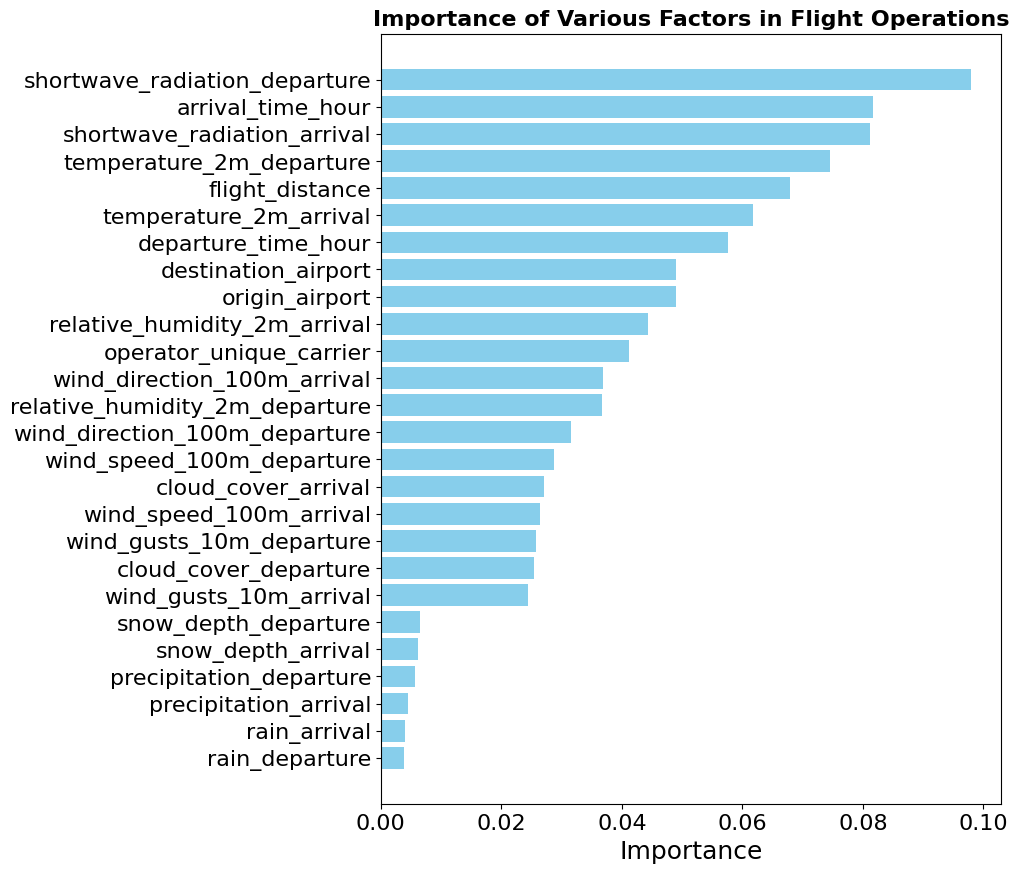

In [23]:

feature_importances = feature_importances.sort_values(by='importance', ascending=True)

# Creating the bar chart
plt.figure(figsize=(8, 10))
plt.barh(feature_importances.index, feature_importances['importance'], color='skyblue')
plt.xlabel('Importance', fontsize=18) # Increase font size for x-axis label
plt.title('Importance of Various Factors in Flight Operations', fontsize=16, fontweight='bold') # Bold and increase font size for title
plt.xticks(fontsize=16) # Increase font size for x-axis ticks
plt.yticks(fontsize=16) # Increase font size for y-axis ticks
plt.show()


Plot 2 - Average departure delay and arrival delay vs Time Hour (UTC)

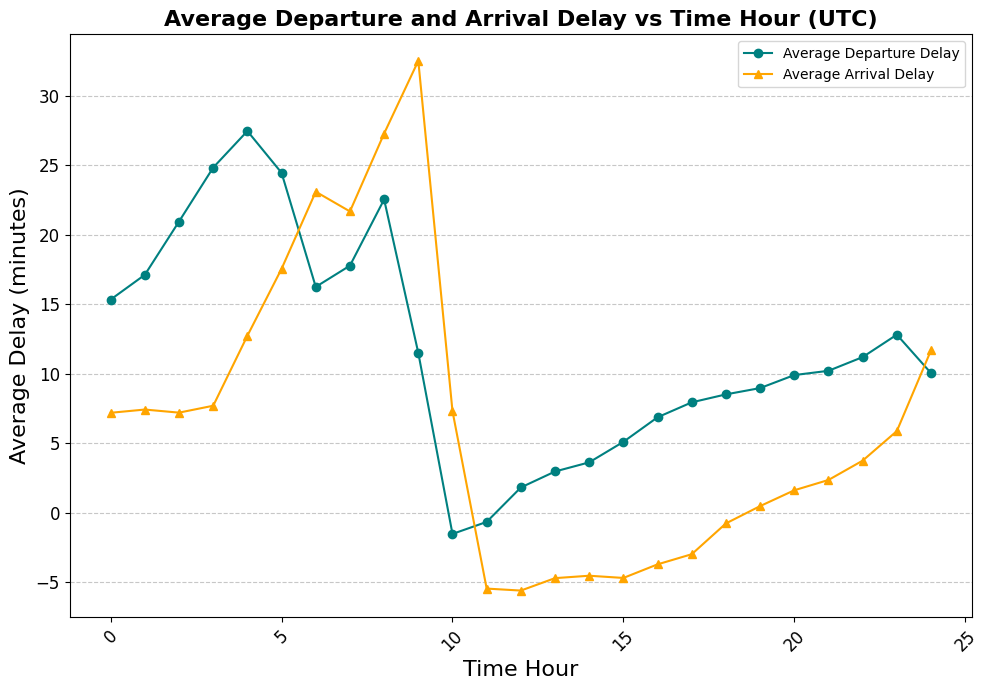

In [24]:

# Assuming flight_df is already defined and contains the necessary data

# Grouping for departure data
grouped_dep = master_df.groupby('DEP_TIME_HOUR')['DEP_DELAY'].mean()

# Grouping for arrival data
grouped_arr = master_df.groupby('ARR_TIME_HOUR')['ARR_DELAY'].mean()

# Enhanced plotting
plt.figure(figsize=(10, 7))

# Plotting departure data
ax1 = grouped_dep.plot(kind='line', color='teal', label='Average Departure Delay', marker='o')

# Plotting arrival data
ax2 = grouped_arr.plot(kind='line', color='orange', label='Average Arrival Delay', marker='^')

# Title and labels with enhanced font settings
plt.title('Average Departure and Arrival Delay vs Time Hour (UTC)', fontsize=16, fontweight='bold')
plt.xlabel('Time Hour', fontsize=16)
plt.ylabel('Average Delay (minutes)', fontsize=16)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Adding legend
plt.legend()

# Adding gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Optionally, add annotations here if needed

# Layout adjustment and show plot
plt.tight_layout()
plt.show()


Plot 3 - Total Flight Delays at Airport Heatmap

In [ ]:
master_df = pd.read_csv("data/merged-final-data/Final_Merged_July_21_June_23.csv")

In [6]:
def get_lat_lon(airport_code, data_type):
    if airport_code in airports:
        return airports[airport_code].get(data_type, None)
    return None

In [7]:
final_df = master_df.copy()

In [8]:
final_df['lat_origin'] = final_df['ORIGIN'].apply(lambda x: get_lat_lon(x, 'lat'))
final_df['lon_origin'] = final_df['ORIGIN'].apply(lambda x: get_lat_lon(x, 'lon'))
final_df['lat_dest'] = final_df['DEST'].apply(lambda x: get_lat_lon(x, 'lat'))
final_df['lon_dest'] = final_df['DEST'].apply(lambda x: get_lat_lon(x, 'lon'))

In [9]:
flight_data = final_df.copy()

In [10]:
flight_data.head()

,FL_DATE,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_NM,DEST,DEST_CITY_NAME,DEST_STATE_NM,...,cloud_cover_ARR,shortwave_radiation_ARR,wind_speed_100m_ARR,wind_gusts_10m_ARR,relative_humidity_2m_ARR,time_only_ARR,lat_origin,lon_origin,lat_dest,lon_dest
0,2022-11-01,AA,N437AN,399,ANC,"Anchorage, AK",Alaska,DFW,"Dallas/Fort Worth, TX",Texas,...,10.200001,0.0,12.758432,11.159999,87.403984,12:00:00,61.174085,-149.998138,32.897233,-97.037695
1,2022-11-01,AS,N536AS,722,ANC,"Anchorage, AK",Alaska,ORD,"Chicago, IL",Illinois,...,0.000000,13.0,20.598795,15.480000,91.071490,13:00:00,61.174085,-149.998138,41.976940,-87.908150
2,2022-11-01,AS,N611AS,426,ANC,"Anchorage, AK",Alaska,FAI,"Fairbanks, AK",Alaska,...,0.000000,0.0,6.638072,8.280000,84.571365,07:00:00,61.174085,-149.998138,64.815356,-147.856667
3,2022-11-01,DL,N801DZ,371,ANC,"Anchorage, AK",Alaska,MSP,"Minneapolis, MN",Minnesota,...,0.000000,0.0,18.089775,14.040000,80.076004,12:00:00,61.174085,-149.998138,44.881972,-93.221778
4,2022-11-01,AA,N437AN,399,DFW,"Dallas/Fort Worth, TX",Texas,ANC,"Anchorage, AK",Alaska,...,57.000004,0.0,26.459389,28.440000,46.712715,04:00:00,32.897233,-97.037695,61.174085,-149.998138


In [11]:

# Aggregating average delays for each airport
origin_delays = flight_data.groupby('ORIGIN')['DEP_DELAY'].mean().reset_index()
destination_delays = flight_data.groupby('DEST')['ARR_DELAY'].mean().reset_index()



# Renaming columns for clarity
origin_delays.rename(columns={'ORIGIN': 'Airport', 'DEP_DELAY': 'Average_Departure_Delay'}, inplace=True)
destination_delays.rename(columns={'DEST': 'Airport', 'ARR_DELAY': 'Average_Arrival_Delay'}, inplace=True)

# Merging the coordinates with the delay data
origin_geo_data = origin_delays.merge(flight_data[['ORIGIN', 'lat_origin', 'lon_origin']].drop_duplicates(),
                                      left_on='Airport', right_on='ORIGIN')
destination_geo_data = destination_delays.merge(flight_data[['DEST', 'lat_dest', 'lon_dest']].drop_duplicates(),
                                                left_on='Airport', right_on='DEST')

# Creating GeoDataFrames
gdf_origin = gpd.GeoDataFrame(origin_geo_data,
                              geometry=gpd.points_from_xy(origin_geo_data.lon_origin, origin_geo_data.lat_origin))
gdf_destination = gpd.GeoDataFrame(destination_geo_data,
                                   geometry=gpd.points_from_xy(destination_geo_data.lon_dest, destination_geo_data.lat_dest))

# # Plotting the heatmaps for departure and arrival delays
# fig, ax = plt.subplots(1, 2, figsize=(15, 7), constrained_layout=True)
# fig.suptitle('Flight Delay Hotspots', fontsize=16)

# # Heatmap for Departure Delays
# gdf_origin.plot(column='Average_Departure_Delay', cmap='viridis', ax=ax[0], legend=True, markersize=10)
# ax[0].set_title('Departure Delay Hotspots')
# ax[0].set_xlabel('Longitude')
# ax[0].set_ylabel('Latitude')

# # Heatmap for Arrival Delays
# gdf_destination.plot(column='Average_Arrival_Delay', cmap='viridis', ax=ax[1], legend=True, markersize=10)
# ax[1].set_title('Arrival Delay Hotspots')
# ax[1].set_xlabel('Longitude')
# ax[1].set_ylabel('Latitude')

# plt.show()


In [12]:
delay_combined_merge = pd.merge(origin_geo_data,destination_geo_data,left_on=['lon_origin','lat_origin'],right_on=['lon_dest','lat_dest'],how='inner')
delay_combined_merge['total_delay'] = delay_combined_merge['Average_Departure_Delay'] + delay_combined_merge['Average_Arrival_Delay']

In [13]:
# Extracting coordinates and average delays for origin and destination airports
origin_coords_delays = gdf_origin[['lon_origin', 'lat_origin', 'Average_Departure_Delay']]
destination_coords_delays = gdf_destination[['lon_dest', 'lat_dest', 'Average_Arrival_Delay']]



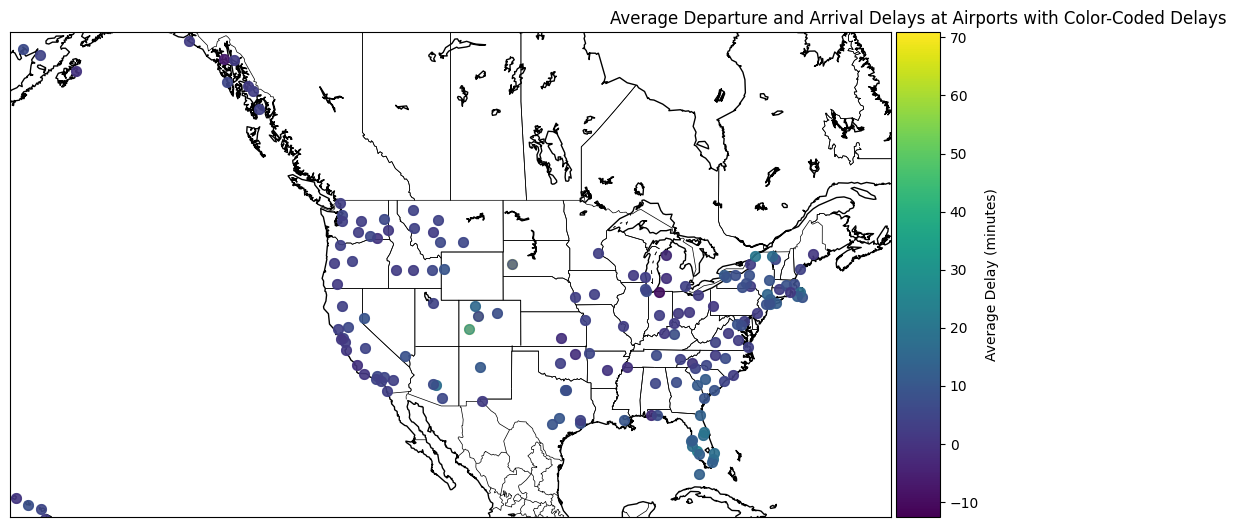

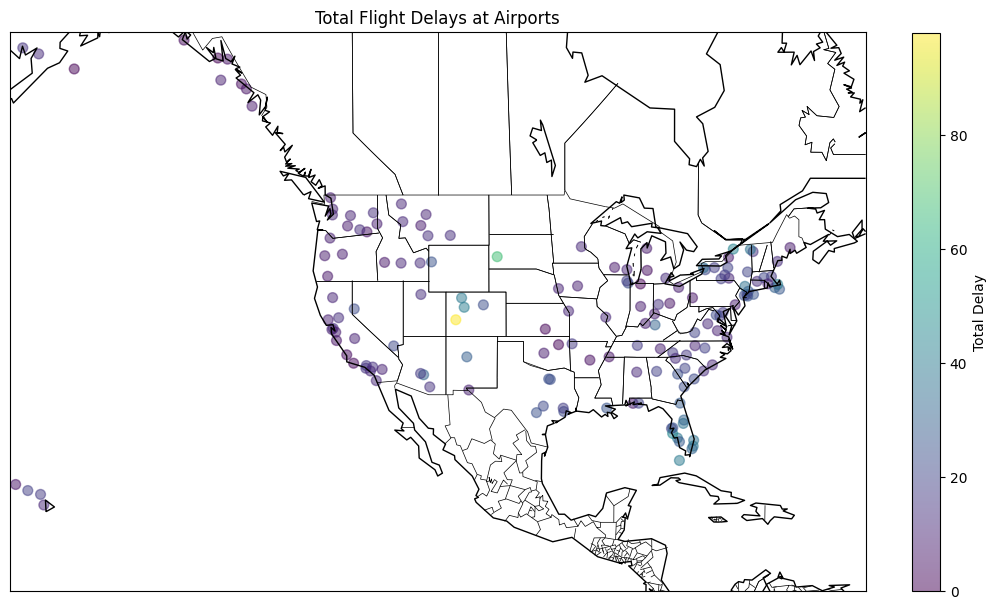

In [15]:

# Load the dataset
# Adjust the path if your file is located differently
plot_data = delay_combined_merge.copy()

# Handling negative or NaN values in 'total_delay'
plot_data['total_delay'] = plot_data['total_delay'].apply(lambda x: max(x, 0))
plot_data.dropna(subset=['total_delay'], inplace=True)

# Setting up the plot for the map
plt.figure(figsize=(12, 8))
m = Basemap(projection='merc', llcrnrlat=10, urcrnrlat=60, llcrnrlon=-160, urcrnrlon=-60, lat_ts=10, resolution='c')
m.drawcoastlines()
m.drawcountries()
m.drawstates()

# Define a colormap
cmap = plt.cm.viridis

# Plotting the total delay points
x, y = m(plot_data['lon_origin'].values, plot_data['lat_origin'].values)  # Vectorized mapping
sc = m.scatter(x, y, c=plot_data['total_delay'], s=50, cmap=cmap, alpha=0.5, vmin=plot_data['total_delay'].min(), vmax=plot_data['total_delay'].max())

# Creating a colorbar as a legend
cb = plt.colorbar(sc, orientation='vertical', label='Total Delay', fraction=0.03, ax=plt.gca())

plt.title("Total Flight Delays at Airports")
plt.show()


Plot 5 - Impact of various weather conditions on average Departure delays

In [16]:
flight_data = final_df.copy()

In [18]:
# Defining thresholds for categorizing weather conditions
wind_speed_threshold = flight_data['wind_speed_100m_DEP'].quantile(0.9)  # High wind speed threshold (75th percentile)
#cloud_cover_threshold = 0.75  # Assuming cloud cover above 75% indicates low visibility
#umidity_threshold = flight_data['relative_humidity_2m_DEP'].quantile(0.75)  # High humidity threshold (75th percentile)
snowfall_threshold = flight_data['snow_depth_DEP'].quantile(0.9)
precipitation_threshold = flight_data['precipitation_DEP'].quantile(0.9)
#visibility_low  = flight_data['cloud_cover_DEP'].quantile(0.75)



# Categorizing flights based on weather conditions
flight_data['High_Wind'] = flight_data['wind_speed_100m_DEP'] >= wind_speed_threshold
# flight_data['Low_Visibility'] = flight_data['cloud_cover_ARR'] >= cloud_cover_threshold
# flight_data['High_Humidity'] = flight_data['relative_humidity_2m_DEP'] >= humidity_threshold
flight_data['Snowfall'] = flight_data['snow_depth_DEP'] >= snowfall_threshold
flight_data['Precipitation'] = flight_data['precipitation_DEP'] >= precipitation_threshold
#flight_data['Low_visibility'] = flight_data['cloud_cover_DEP'] >= visibility_low


# Calculating average delays for each weather condition
# weather_conditions = ['High_Wind', 'Low_Visibility', 'High_Humidity','Snowfall','Precipitation','Low_visibility']
weather_conditions = ['High_Wind','Snowfall','Precipitation']
weather_impact_analysis = flight_data.groupby(weather_conditions).agg({'DEP_DELAY':'mean'}).reset_index()


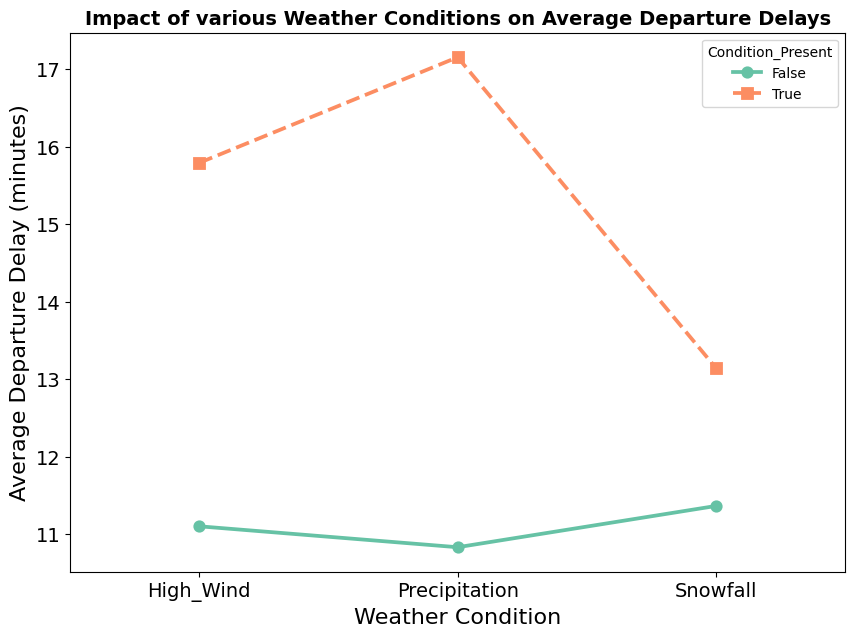

In [19]:
# Preparing the data for the combined plot
# Creating a melted version of the data for easier plotting with seaborn
# melted_weather_data = pd.melt(flight_data, id_vars=['DEP_DELAY'],
#                               value_vars=['High_Wind', 'Low_Visibility', 'High_Humidity','snowfall','Precipitation','Low_visibility'],
#                               var_name='Weather_Condition', value_name='Condition_Present')

melted_weather_data = pd.melt(flight_data, id_vars=['DEP_DELAY'],
                              value_vars=['High_Wind','Snowfall','Precipitation'],
                              var_name='Weather_Condition', value_name='Condition_Present')

# Calculating average delay for each weather condition
average_delays_by_condition = melted_weather_data.groupby(['Weather_Condition', 'Condition_Present']).agg({'DEP_DELAY':'mean'}).reset_index()

# Creating the combined plot
plt.figure(figsize=(10, 7))
sns.pointplot(x='Weather_Condition', y='DEP_DELAY', hue='Condition_Present', data=average_delays_by_condition, palette='Set2', markers=["o", "s"], linestyles=["-", "--"])
plt.title('Impact of various Weather Conditions on Average Departure Delays', fontsize="14", fontweight="bold")
plt.xlabel('Weather Condition',fontsize="16")
plt.ylabel('Average Departure Delay (minutes)',fontsize="16")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
